In [2]:
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns

# Set random seed for reproducibility
np.random.seed(42)

In [3]:
class GridWorld:
    """Simple GridWorld environment for RL"""
    def __init__(self, size=5):
        self.size = size
        self.start = (0, 0)
        self.goal = (size-1, size-1)
        self.state = self.start
        self.actions = ['up', 'down', 'left', 'right']

    def reset(self):
        self.state = self.start
        return self.state

    def step(self, action):
        x, y = self.state

        # Action effects
        if action == 'up':
            x = max(0, x - 1)
        elif action == 'down':
            x = min(self.size - 1, x + 1)
        elif action == 'left':
            y = max(0, y - 1)
        elif action == 'right':
            y = min(self.size - 1, y + 1)

        self.state = (x, y)

        # Reward structure
        if self.state == self.goal:
            reward = 10
            done = True
        else:
            reward = -1
            done = False

        return self.state, reward, done

    def get_action_index(self, action):
        return self.actions.index(action)

In [4]:
class TDZeroAgent:
    """Temporal Difference TD(0) Learning Agent"""
    def __init__(self, env, alpha=0.1, gamma=0.9, epsilon=0.1):
        self.env = env
        self.alpha = alpha  # Learning rate
        self.gamma = gamma  # Discount factor
        self.epsilon = epsilon  # Exploration rate
        self.V = defaultdict(float)  # State values

    def choose_action(self):
        """Random policy for TD(0) value estimation"""
        return np.random.choice(self.env.actions)

    def train(self, episodes=1000):
        """Train using TD(0) bootstrapping"""
        episode_rewards = []

        for episode in range(episodes):
            state = self.env.reset()
            total_reward = 0

            while True:
                action = self.choose_action()
                next_state, reward, done = self.env.step(action)
                total_reward += reward

                # TD(0) Update: V(s) <- V(s) + α[r + γV(s') - V(s)]
                td_target = reward + self.gamma * self.V[next_state]
                td_error = td_target - self.V[state]
                self.V[state] += self.alpha * td_error

                if done:
                    break

                state = next_state

            episode_rewards.append(total_reward)

        return episode_rewards

In [5]:
class SARSAAgent:
    """SARSA (On-Policy TD Control) Agent"""
    def __init__(self, env, alpha=0.1, gamma=0.9, epsilon=0.1):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.Q = defaultdict(lambda: np.zeros(len(env.actions)))

    def choose_action(self, state):
        """Epsilon-greedy action selection"""
        if np.random.random() < self.epsilon:
            return np.random.choice(self.env.actions)
        else:
            action_values = self.Q[state]
            return self.env.actions[np.argmax(action_values)]

    def train(self, episodes=1000):
        """Train using SARSA bootstrapping"""
        episode_rewards = []

        for episode in range(episodes):
            state = self.env.reset()
            action = self.choose_action(state)
            total_reward = 0

            while True:
                next_state, reward, done = self.env.step(action)
                total_reward += reward
                next_action = self.choose_action(next_state)

                # SARSA Update: Q(s,a) <- Q(s,a) + α[r + γQ(s',a') - Q(s,a)]
                action_idx = self.env.get_action_index(action)
                next_action_idx = self.env.get_action_index(next_action)

                td_target = reward + self.gamma * self.Q[next_state][next_action_idx]
                td_error = td_target - self.Q[state][action_idx]
                self.Q[state][action_idx] += self.alpha * td_error

                if done:
                    break

                state = next_state
                action = next_action

            episode_rewards.append(total_reward)

        return episode_rewards

In [6]:
class QLearningAgent:
    """Q-Learning (Off-Policy TD Control) Agent"""
    def __init__(self, env, alpha=0.1, gamma=0.9, epsilon=0.1):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.Q = defaultdict(lambda: np.zeros(len(env.actions)))

    def choose_action(self, state):
        """Epsilon-greedy action selection"""
        if np.random.random() < self.epsilon:
            return np.random.choice(self.env.actions)
        else:
            action_values = self.Q[state]
            return self.env.actions[np.argmax(action_values)]

    def train(self, episodes=1000):
        """Train using Q-Learning bootstrapping"""
        episode_rewards = []

        for episode in range(episodes):
            state = self.env.reset()
            total_reward = 0

            while True:
                action = self.choose_action(state)
                next_state, reward, done = self.env.step(action)
                total_reward += reward

                # Q-Learning Update: Q(s,a) <- Q(s,a) + α[r + γ max Q(s',a') - Q(s,a)]
                action_idx = self.env.get_action_index(action)

                td_target = reward + self.gamma * np.max(self.Q[next_state])
                td_error = td_target - self.Q[state][action_idx]
                self.Q[state][action_idx] += self.alpha * td_error

                if done:
                    break

                state = next_state

            episode_rewards.append(total_reward)

        return episode_rewards

In [7]:
class NStepTDAgent:
    """N-Step Temporal Difference Agent"""
    def __init__(self, env, n=3, alpha=0.1, gamma=0.9, epsilon=0.1):
        self.env = env
        self.n = n  # Number of steps for bootstrapping
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.Q = defaultdict(lambda: np.zeros(len(env.actions)))

    def choose_action(self, state):
        """Epsilon-greedy action selection"""
        if np.random.random() < self.epsilon:
            return np.random.choice(self.env.actions)
        else:
            action_values = self.Q[state]
            return self.env.actions[np.argmax(action_values)]

    def train(self, episodes=1000):
        """Train using n-step TD bootstrapping"""
        episode_rewards = []

        for episode in range(episodes):
            state = self.env.reset()

            # Buffers to store history for one episode
            states_hist = [state] # S_0, S_1, ..., S_T
            actions_hist = []     # A_0, A_1, ..., A_{T-1}
            rewards_hist = []     # R_1, R_2, ..., R_T (these are the rewards received)

            total_reward = 0
            t = 0 # Current timestep in the episode (action A_t taken from S_t)

            # --- Episode Simulation ---
            while True:
                action = self.choose_action(states_hist[t]) # A_t from S_t
                actions_hist.append(action)

                next_state, reward, done = self.env.step(action) # S_{t+1}, R_{t+1}
                total_reward += reward

                states_hist.append(next_state) # S_{t+1}
                rewards_hist.append(reward) # R_{t+1}

                if done:
                    break # Episode ends, all history for this episode is collected

                t += 1 # Move to next timestep

            episode_rewards.append(total_reward)

            # T is now the actual length of the episode (number of steps taken before `done=True`)
            # len(states_hist) = T+1 (S_0 to S_T)
            # len(actions_hist) = T (A_0 to A_{T-1})
            # len(rewards_hist) = T (R_1 to R_T)

            # --- N-step TD Updates ---
            # Loop for tau (timestep of the state-action pair to update)
            # tau can go from 0 up to T-1
            T_episode_length = len(rewards_hist) # This is T, the number of transitions

            for tau in range(T_episode_length):
                G = 0

                # Sum rewards for n steps, or until episode end
                # R_{tau+k+1} is rewards_hist[tau+k]

                end_idx_for_rewards_sum = min(tau + self.n, T_episode_length)
                for k_idx in range(tau, end_idx_for_rewards_sum):
                    G += self.gamma**(k_idx - tau) * rewards_hist[k_idx]

                # Add bootstrapping term if not reached terminal state within n steps
                # i.e., S_{tau+n} is not S_T
                # This condition is equivalent to `tau + self.n < T_episode_length`
                if tau + self.n < T_episode_length:
                    # Q(S_{tau+n}, A_{tau+n})
                    # S_{tau+n} is states_hist[tau + self.n]
                    # A_{tau+n} is actions_hist[tau + self.n]

                    state_to_bootstrap = states_hist[tau + self.n]
                    action_to_bootstrap = actions_hist[tau + self.n]
                    action_idx_to_bootstrap = self.env.get_action_index(action_to_bootstrap)
                    G += self.gamma**self.n * self.Q[state_to_bootstrap][action_idx_to_bootstrap]

                # Update Q-value for (S_tau, A_tau)
                state_tau = states_hist[tau]
                action_tau = actions_hist[tau]
                action_idx_tau = self.env.get_action_index(action_tau)
                self.Q[state_tau][action_idx_tau] += self.alpha * (G - self.Q[state_tau][action_idx_tau])

        return episode_rewards

In [8]:
def smooth_rewards(rewards, window=50):
    """Smooth rewards for better visualization"""
    return np.convolve(rewards, np.ones(window)/window, mode='valid')

In [9]:
def visualize_results(results_dict):
    """Visualize learning curves for all algorithms"""
    plt.figure(figsize=(14, 6))

    # Plot 1: Learning curves
    plt.subplot(1, 2, 1)
    for name, rewards in results_dict.items():
        smoothed = smooth_rewards(rewards)
        plt.plot(smoothed, label=name, linewidth=2)

    plt.xlabel('Episode', fontsize=12)
    plt.ylabel('Total Reward (Smoothed)', fontsize=12)
    plt.title('RL Bootstrapping Methods Comparison', fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot 2: Final performance comparison
    plt.subplot(1, 2, 2)
    final_performance = {name: np.mean(rewards[-100:])
                        for name, rewards in results_dict.items()}

    names = list(final_performance.keys())
    values = list(final_performance.values())
    colors = plt.cm.viridis(np.linspace(0, 1, len(names)))

    bars = plt.bar(names, values, color=colors, alpha=0.7, edgecolor='black')
    plt.ylabel('Average Reward (Last 100 Episodes)', fontsize=12)
    plt.title('Final Performance Comparison', fontsize=14, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, alpha=0.3, axis='y')

    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}',
                ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.show()

In [10]:
print("=" * 60)
print("Reinforcement Learning with Bootstrapping Techniques")
print("=" * 60)

episodes = 500
results = {}

Reinforcement Learning with Bootstrapping Techniques


In [11]:
# TD(0) Learning
print("\n1. Training TD(0) Agent...")
env = GridWorld(size=5)
td_agent = TDZeroAgent(env)
td_rewards = td_agent.train(episodes)
results['TD(0)'] = td_rewards
print(f"   Final average reward: {np.mean(td_rewards[-100:]):.2f}")


1. Training TD(0) Agent...
   Final average reward: -106.68


In [12]:
# SARSA Learning
print("\n2. Training SARSA Agent...")
env = GridWorld(size=5)
sarsa_agent = SARSAAgent(env)
sarsa_rewards = sarsa_agent.train(episodes)
results['SARSA'] = sarsa_rewards
print(f"   Final average reward: {np.mean(sarsa_rewards[-100:]):.2f}")


2. Training SARSA Agent...
   Final average reward: 2.07


In [13]:
# Q-Learning
print("\n3. Training Q-Learning Agent...")
env = GridWorld(size=5)
q_agent = QLearningAgent(env)
q_rewards = q_agent.train(episodes)
results['Q-Learning'] = q_rewards
print(f"   Final average reward: {np.mean(q_rewards[-100:]):.2f}")


3. Training Q-Learning Agent...
   Final average reward: 2.05


In [14]:
# 3-Step TD
print("\n4. Training 3-Step TD Agent...")
env = GridWorld(size=5)
nstep_agent = NStepTDAgent(env, n=3)
nstep_rewards = nstep_agent.train(episodes)
results['3-Step TD'] = nstep_rewards
print(f"   Final average reward: {np.mean(nstep_rewards[-100:]):.2f}")


4. Training 3-Step TD Agent...
   Final average reward: 1.65



Training complete! Displaying results...


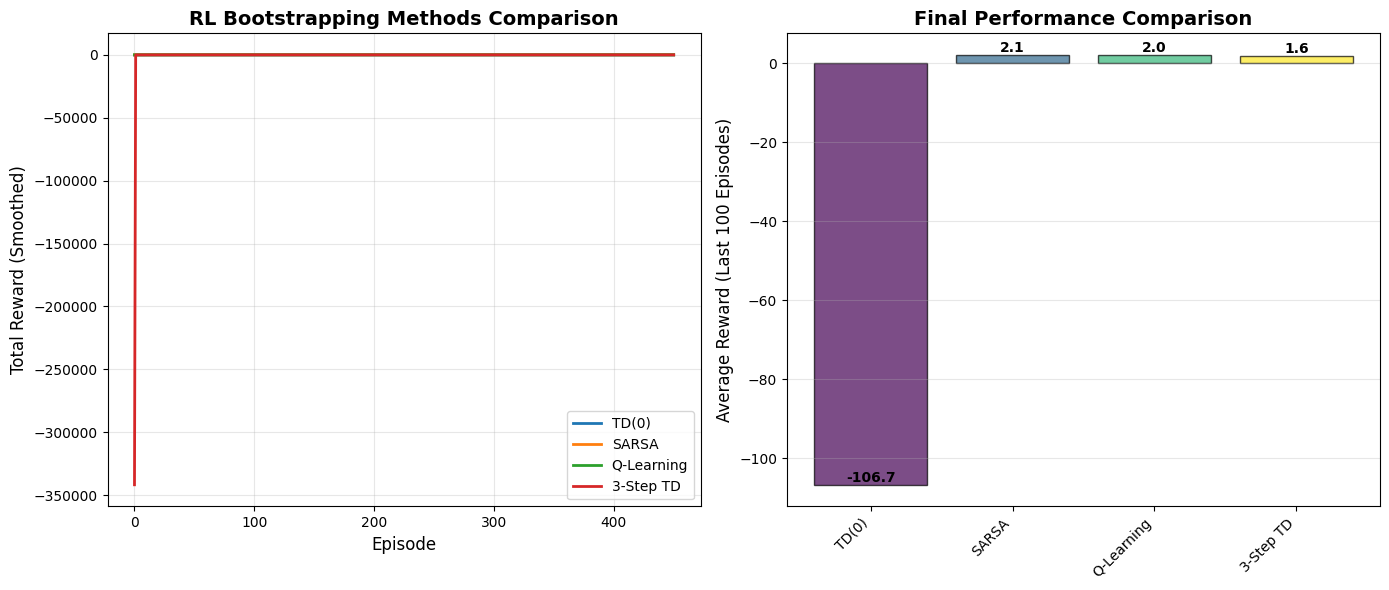

In [15]:
# Visualize results
print("\n" + "=" * 60)
print("Training complete! Displaying results...")
print("=" * 60)
visualize_results(results)

In [16]:
# Print summary statistics
print("\n" + "=" * 60)
print("Summary Statistics (Last 100 Episodes):")
print("=" * 60)
for name, rewards in results.items():
    final_rewards = rewards[-100:]
    print(f"\n{name}:")
    print(f"  Mean:   {np.mean(final_rewards):.2f}")
    print(f"  Std:    {np.std(final_rewards):.2f}")
    print(f"  Min:    {np.min(final_rewards):.2f}")
    print(f"  Max:    {np.max(final_rewards):.2f}")


Summary Statistics (Last 100 Episodes):

TD(0):
  Mean:   -106.68
  Std:    102.32
  Min:    -572.00
  Max:    -4.00

SARSA:
  Mean:   2.07
  Std:    1.27
  Min:    -3.00
  Max:    3.00

Q-Learning:
  Mean:   2.05
  Std:    1.49
  Min:    -3.00
  Max:    3.00

3-Step TD:
  Mean:   1.65
  Std:    2.33
  Min:    -10.00
  Max:    3.00



Comparing Different N-Step Values

Training 1-Step TD Agent...
   Final average reward: 2.37

Training 3-Step TD Agent...
   Final average reward: 2.16

Training 5-Step TD Agent...
   Final average reward: 2.00

Training 10-Step TD Agent...
   Final average reward: 1.75


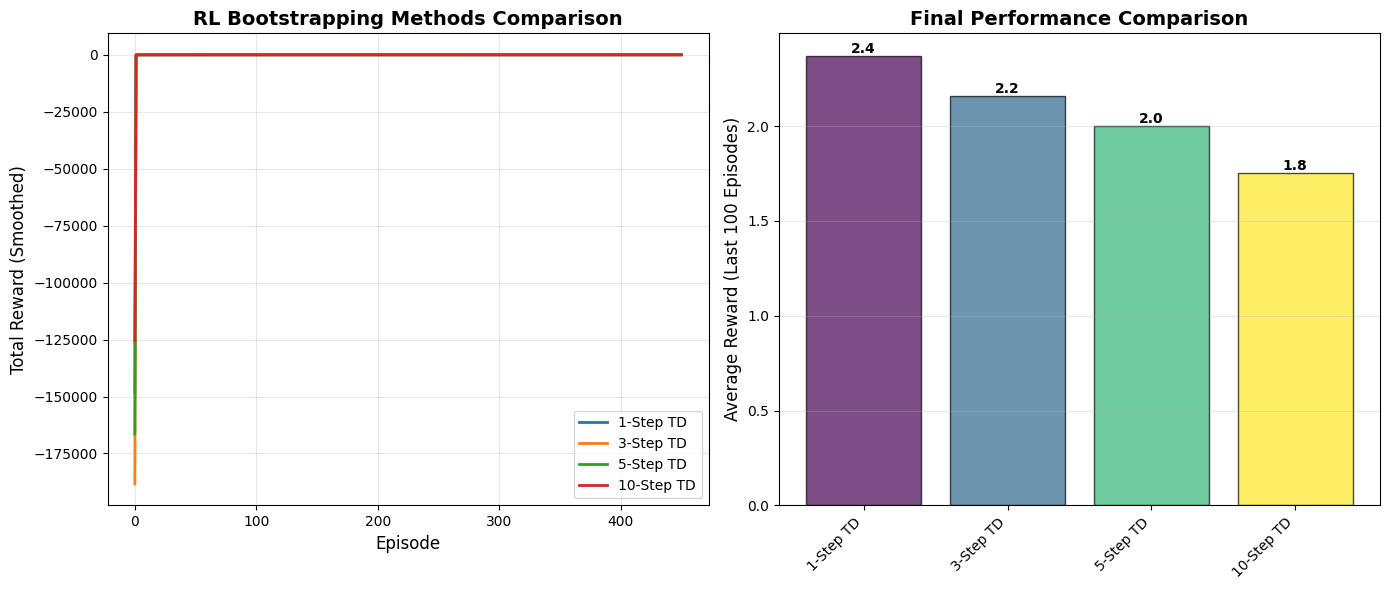

In [17]:
# Compare different n-step values
print("\n" + "=" * 60)
print("Comparing Different N-Step Values")
print("=" * 60)

n_step_comparison = {}
for n in [1, 3, 5, 10]:
    print(f"\nTraining {n}-Step TD Agent...")
    env = GridWorld(size=5)
    agent = NStepTDAgent(env, n=n)
    rewards = agent.train(episodes)
    n_step_comparison[f'{n}-Step TD'] = rewards
    print(f"   Final average reward: {np.mean(rewards[-100:]):.2f}")

visualize_results(n_step_comparison)